<center>
    <h3>Fundamentals of Artificial Intelligence and Knowledge Representation -
Module 3</h3>
    <h1>Flood disaster prediction</h1>
    <h5>Antonio Politano, Francesco Pieroni and Riccardo Spolaor</h5>
</center>

Due to recent *climate change* related issues critical floods on urban areas have started becoming more and more common. Hence, a software able to estimate the likelihood of such an event could be an useful tool in order to prevent the most dramatic scenarios.

For this reason we proposed the implementation of a *Bayesian Network* to model the likelihood of floods in various municipalities of the Italian Veneto region. The structure of the network was inspired by the paper (https://www.tandfonline.com/doi/full/10.1080/19475705.2019.1685010), although quite deeply modified for didactic reasons.

## Libraries import and initialization

In [1]:
import warnings
# Suppress pgmpy internal deprecated use of third party libraries.
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress UserWarning related to machine precision calculations of percentage.
warnings.simplefilter(action='ignore', category=UserWarning)

# Import internal modules.
from utils import *
from variables import *
from extended_classes import *
from graphics import *

# Import pgmpy modules.
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination, ApproxInference
from pgmpy.sampling import GibbsSampling

# Import graphics related libraries and modules.
import matplotlib.pyplot as plt
from IPython.display import display

# Import other useful librares and modules.
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)

In [3]:
%matplotlib inline

# 1 Bayesian Network construction
A *Bayesian network* is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph. The process to build a *Bayesian Network* consists in defining its *variable nodes*; the *states* of each node; the *parent* of each node; the *edges* of the network and the *Conditional Probability Distribution (CPD)* tables for each variable.

## 1.1 Variable nodes:
The Bayesian Network is composed by nine nodes which are listed below:
* **Flood**: It describes the likelihood of particularly serious floods on a yearly basis;
* **Road density**: It illustrates the density of paved surfaces discretized in three levels: *dense*, *medium* and *sparse*.
Intuitively the higher the road density the higher the chances of a serious flood;
* **Slope**: It explains whether the considered area is *steep* or *flat*. Obviously a flat area has more chances
to be flooded;
* **Rainfall Amount**: It summarizes the average amount of water present on the ground in a year which of course
increases the chances of flooding. The possible values are *huge*, *medium* and *little*;
* **Population density**: It shows the density of the population of an area and it can be *high*, *medium* or *low*. A densely populated area requires a higher presence of roads;
* **Per unit GDP**: It describes the average richness of people in the area divided into the categories: *high*, *medium* and *low*;
* **Elevation**: It illustrates the elevation of the territory in exam. It can be *high*, *medium* or *low*.
* **Rainfall frequency**: It explains the average rainfall frequency observed in a year. It is discretized in the values *frequent*, *medium* and *rare*;
* **River density**: It shows the density of rivers or other water elements in an area. It can be either *dense* or *sparse*.

In [4]:
variables = [
    PER_UNIT_GDP,
    POPULATION_DENSITY,
    ROAD_DENSITY,
    ELEVATION,
    SLOPE,
    RAINFALL_FREQUENCY,
    RIVER_DENSITY,
    RAINFALL_AMOUNT,
    FLOOD
]
print(f"Variables: {'; '.join(variables)}")

Variables: Per unit GDP; Population density; Road density; Elevation; Slope; Rainfall frequency; River density; Rainfall amount; Flood


## 1.2 Node states:
The states of the variables expressed in each node are discretized into two or three values.

In [5]:
state_names_dictionary = {
    PER_UNIT_GDP: ['High', 'Medium', 'Low'],
    POPULATION_DENSITY: ['Dense', 'Medium', 'Sparse'],
    ROAD_DENSITY: ['Dense', 'Medium', 'Sparse'],
    ELEVATION: ['High', 'Medium', 'Low'],
    SLOPE: ['Steep', 'Flat'],
    RAINFALL_FREQUENCY: ['Frequent', 'Medium', 'Rare'],
    RIVER_DENSITY: ['Dense', 'Sparse'],
    RAINFALL_AMOUNT: ['Huge', 'Medium', 'Little'],
    FLOOD: ['Yes', 'No']
}

## 1.3 Parent nodes:
The parents nodes of each variable are expressed below.

In [6]:
evidence_dictionary = {
    PER_UNIT_GDP: None,
    POPULATION_DENSITY: [PER_UNIT_GDP],
    ROAD_DENSITY: [PER_UNIT_GDP, POPULATION_DENSITY],
    ELEVATION: None,
    SLOPE: [ELEVATION],
    RAINFALL_FREQUENCY: None,
    RIVER_DENSITY: None,
    RAINFALL_AMOUNT: [RAINFALL_FREQUENCY, RIVER_DENSITY],
    FLOOD: [ROAD_DENSITY, SLOPE, RAINFALL_AMOUNT]
}

## 1.4 Edges
The edges connecting each node with its children in the Network are presented.

In [7]:
edges = [
    (PER_UNIT_GDP, POPULATION_DENSITY),
    (PER_UNIT_GDP, ROAD_DENSITY), 
    (POPULATION_DENSITY, ROAD_DENSITY),
    (ROAD_DENSITY, FLOOD),
    (ELEVATION, SLOPE),
    (SLOPE, FLOOD),
    (RAINFALL_FREQUENCY, RAINFALL_AMOUNT),
    (RIVER_DENSITY, RAINFALL_AMOUNT),
    (RAINFALL_AMOUNT, FLOOD)
]

## 1.5 CPDs tables
The data needed to build the *Conditional Probability Distribution (CPD)* tables. Each *CPD* is built by assigning a probability value to each one of its discrete state given the evidence of the various combinations of the discrete states of its parents.

The data presented in this Notebook is obtained throgh a qualitative approach.
The sources of each piece of information are expressed below:
* *Per unit GDP* and *Population density*: https://www.venetoeconomia.it/2019/04/redditi-veneto-treviso-porto-tolle/;
* *Elevation* and *Slope*: https://it-ch.topographic-map.com/maps/gprg/Italia/;
* *River density*: https://emanuelemartino.files.wordpress.com/2020/01/fiumi-principali.gif?w=736;
* *Road density*: https://www.stradeanas.it/it/le-strade/anas-regione;
* *Rainfall frequency*, *Rainfall amount* and *Flood*: https://www.arpa.veneto.it/arpavinforma/indicatori-ambientali/indicatori_ambientali/clima-e-rischi-naturali/clima/precipitazione-annua/view;

In [8]:
values_dictionary = {
    PER_UNIT_GDP: [
        [0.3], 
        [0.63], 
        [0.07]
    ],
    POPULATION_DENSITY: [
        [0.7, 0.3, 0.05],
        [0.2, 0.55, 0.25],
        [0.1, 0.15, 0.7],
    ],
    ROAD_DENSITY: [
        [0.8, 0.7, 0.1, 0.6, 0.4, 0.1, 0.1, 0.05, 0.01],
        [0.19, 0.25, 0.35, 0.3, 0.5, 0.25, 0.25, 0.2, 0.15],
        [0.01, 0.05, 0.55, 0.1, 0.1, 0.65, 0.65, 0.75, 0.84]
    ],
    ELEVATION: [
        [0.15],
        [0.1], 
        [0.75]
    ],
    SLOPE: [
        [0.75, 0.6, 0.05], 
        [0.25, 0.4, 0.95]
    ],
    RAINFALL_FREQUENCY: [
        [0.3], 
        [0.6], 
        [0.1]
    ],
    RIVER_DENSITY: [
        [0.4], 
        [0.6]
    ],
    RAINFALL_AMOUNT: [
        [0.7, 0.5, 0.55, 0.3, 0.1, 0.01],
        [0.2, 0.25, 0.3, 0.4, 0.3, 0.04],
        [0.1, 0.25, 0.15, 0.3, 0.6, 0.95]
    ],
    FLOOD: [
        [0.07, 0.03, 0.005, 0.2, 0.1, 0.008, 0.05, 0.009, 0.0005, 0.13, 0.08, 0.006, 0.008, 0.002, 0.0001, 0.1, 0.04, 0.0002],
        [0.93, 0.97, 0.995, 0.8, 0.9, 0.992, 0.95, 0.991, 0.9995, 0.87, 0.92, 0.994, 0.992, 0.998, 0.9999, 0.9, 0.96, 0.9998]
    ],
}

In [9]:
cpds = {v: get_tabular_cpd(v, state_names_dictionary, values_dictionary, evidence_dictionary) for v in variables}

The *CPD* tables are shown below

In [10]:
for k, v in cpds.items():
    print('CPD Table for variable: {}'.format(k))
    display(cpd_to_pandas(v))
    print()

CPD Table for variable: Per unit GDP


,
Per unit GDP (High),0.30
Per unit GDP (Medium),0.63
Per unit GDP (Low),0.07



CPD Table for variable: Population density


,Per unit GDP (High),Per unit GDP (Medium),Per unit GDP (Low)
Population density (Dense),0.7,0.30,0.05
Population density (Medium),0.2,0.55,0.25
Population density (Sparse),0.1,0.15,0.70



CPD Table for variable: Road density


Per unit GDP (High)                              \
                      Population density (Dense) Population density (Medium)   
Road density (Dense)                        0.80                        0.70   
Road density (Medium)                       0.19                        0.25   
Road density (Sparse)                       0.01                        0.05   

                                                       Per unit GDP (Medium)  \
                      Population density (Sparse) Population density (Dense)   
Road density (Dense)                         0.10                        0.6   
Road density (Medium)                        0.35                        0.3   
Road density (Sparse)                        0.55                        0.1   

                                                                               \
                      Population density (Medium) Population density (Sparse)   
Road density (Dense)                          0.4                        0.10   
Road density (Medium)                         0.5                        0.25   
Road density (Sparse)                         0.1                        0.65   

                              Per unit GDP (Low)                              \
                      Population density (Dense) Population density (Medium)   
Road density (Dense)                        0.10                        0.05   
Road density (Medium)                       0.25                        0.20   
Road density (Sparse)                       0.65                        0.75   

                                                   
                      Population density (Sparse)  
Road density (Dense)                         0.01  
Road density (Medium)                        0.15  
Road density (Sparse)                        0.84


CPD Table for variable: Elevation


,
Elevation (High),0.15
Elevation (Medium),0.10
Elevation (Low),0.75



CPD Table for variable: Slope


,Elevation (High),Elevation (Medium),Elevation (Low)
Slope (Steep),0.75,0.6,0.05
Slope (Flat),0.25,0.4,0.95



CPD Table for variable: Rainfall frequency


,
Rainfall frequency (Frequent),0.3
Rainfall frequency (Medium),0.6
Rainfall frequency (Rare),0.1



CPD Table for variable: River density


,
River density (Dense),0.4
River density (Sparse),0.6



CPD Table for variable: Rainfall amount


Rainfall frequency (Frequent)                         \
                                 River density (Dense) River density (Sparse)   
Rainfall amount (Huge)                             0.7                   0.50   
Rainfall amount (Medium)                           0.2                   0.25   
Rainfall amount (Little)                           0.1                   0.25   

                         Rainfall frequency (Medium)                         \
                               River density (Dense) River density (Sparse)   
Rainfall amount (Huge)                          0.55                    0.3   
Rainfall amount (Medium)                        0.30                    0.4   
Rainfall amount (Little)                        0.15                    0.3   

                         Rainfall frequency (Rare)                         
                             River density (Dense) River density (Sparse)  
Rainfall amount (Huge)                         0.1                   0.01  
Rainfall amount (Medium)                       0.3                   0.04  
Rainfall amount (Little)                       0.6                   0.95


CPD Table for variable: Flood


Road density (Dense)                           \
                     Slope (Steep)                            
            Rainfall amount (Huge) Rainfall amount (Medium)   
Flood (Yes)                   0.07                     0.03   
Flood (No)                    0.93                     0.97   

                                                             \
                                               Slope (Flat)   
            Rainfall amount (Little) Rainfall amount (Huge)   
Flood (Yes)                    0.005                    0.2   
Flood (No)                     0.995                    0.8   

                                                               \
                                                                
            Rainfall amount (Medium) Rainfall amount (Little)   
Flood (Yes)                      0.1                    0.008   
Flood (No)                       0.9                    0.992   

             Road density (Medium)                           \
                     Slope (Steep)                            
            Rainfall amount (Huge) Rainfall amount (Medium)   
Flood (Yes)                   0.05                    0.009   
Flood (No)                    0.95                    0.991   

                                                             \
                                               Slope (Flat)   
            Rainfall amount (Little) Rainfall amount (Huge)   
Flood (Yes)                   0.0005                   0.13   
Flood (No)                    0.9995                   0.87   

                                                               \
                                                                
            Rainfall amount (Medium) Rainfall amount (Little)   
Flood (Yes)                     0.08                    0.006   
Flood (No)                      0.92                    0.994   

             Road density (Sparse)                           \
                     Slope (Steep)                            
            Rainfall amount (Huge) Rainfall amount (Medium)   
Flood (Yes)                  0.008                    0.002   
Flood (No)                   0.992                    0.998   

                                                             \
                                               Slope (Flat)   
            Rainfall amount (Little) Rainfall amount (Huge)   
Flood (Yes)                   0.0001                    0.1   
Flood (No)                    0.9999                    0.9   

                                                               
                                                               
            Rainfall amount (Medium) Rainfall amount (Little)  
Flood (Yes)                     0.04                   0.0002  
Flood (No)                      0.96                   0.9998

## 1.6 Defining the model structure
The network is defined by just passing a list of edges and then add the already defined CPD tables.

In [11]:
model = ExtendedBayesianNetwork(edges)
model.add_cpds(*[cpds[k] for k in cpds])

In [12]:
print('The model has been correctly developed: {}.'.format(model.check_model()))

The model has been correctly developed: True.


The model consists of the following Bayesian Network:

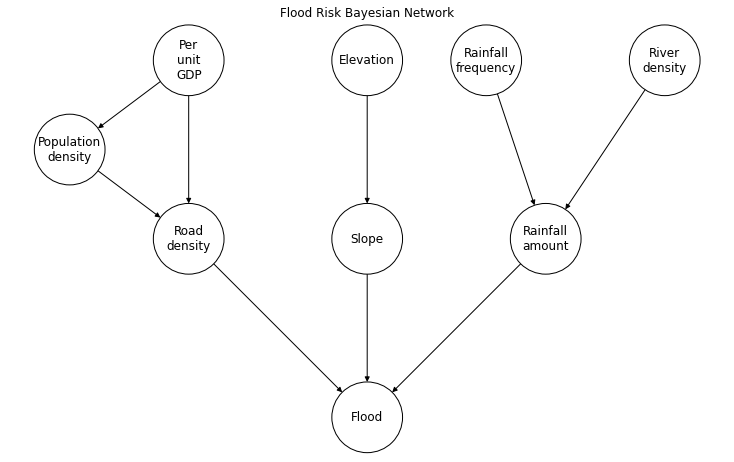

In [13]:
plot_simple_bayesian_network(model)

# 2 Theory concepts

## 2.1 Indepences
The independencies given the parent nodes in the network are expressed through the `pgmpy` method `local_independencies`:

In [14]:
print('Independecies given the parent nodes shown using the function local_independencies:')
model.local_independencies(variables)

Independecies given the parent nodes shown using the function local_independencies:


(Per unit GDP ⟂ Elevation, Rainfall amount, River density, Rainfall frequency, Slope)
(Population density ⟂ Elevation, Rainfall amount, River density, Rainfall frequency, Slope | Per unit GDP)
(Road density ⟂ Elevation, Rainfall amount, River density, Rainfall frequency, Slope | Population density, Per unit GDP)
(Elevation ⟂ Road density, Population density, Rainfall amount, River density, Per unit GDP, Rainfall frequency)
(Slope ⟂ Road density, Population density, Rainfall amount, River density, Per unit GDP, Rainfall frequency | Elevation)
(Rainfall frequency ⟂ Road density, Population density, Elevation, River density, Per unit GDP, Slope)
(River density ⟂ Road density, Population density, Elevation, Per unit GDP, Rainfall frequency, Slope)
(Rainfall amount ⟂ Road density, Population density, Elevation, Per unit GDP, Slope | River density, Rainfall frequency)
(Flood ⟂ Population density, Elevation, River density, Per unit GDP, Rainfall frequency | Road density, Rainfall amount, Slop

## 2.2 Active Trails
To see the *flow of influence*, the active trail of each node without a given evidence is shown with the `pgmpy` method `active_trail_nodes`:

In [15]:
print('Active trail nodes for each variable shown using the function active_trail_nodes:')
for v in variables:
    print(model.active_trail_nodes(v))

Active trail nodes for each variable shown using the function active_trail_nodes:
{'Per unit GDP': {'Road density', 'Population density', 'Per unit GDP', 'Flood'}}
{'Population density': {'Road density', 'Population density', 'Per unit GDP', 'Flood'}}
{'Road density': {'Road density', 'Population density', 'Per unit GDP', 'Flood'}}
{'Elevation': {'Elevation', 'Flood', 'Slope'}}
{'Slope': {'Elevation', 'Flood', 'Slope'}}
{'Rainfall frequency': {'Rainfall amount', 'Rainfall frequency', 'Flood'}}
{'River density': {'River density', 'Rainfall amount', 'Flood'}}
{'Rainfall amount': {'River density', 'Rainfall amount', 'Rainfall frequency', 'Flood'}}
{'Flood': {'Population density', 'Rainfall amount', 'Rainfall frequency', 'Road density', 'Elevation', 'Flood', 'River density', 'Per unit GDP', 'Slope'}}


## 2.3 V-Structure activation
The *V-structure* (*Rainfall frequency*, *Rainfall amount*, *River density*) is activated by the evidence *Rainfall amount*, therefore *River density* influences *Rainfall frequency*.

Trail of influence for variable River density: {'River density': {'River density', 'Rainfall frequency'}}


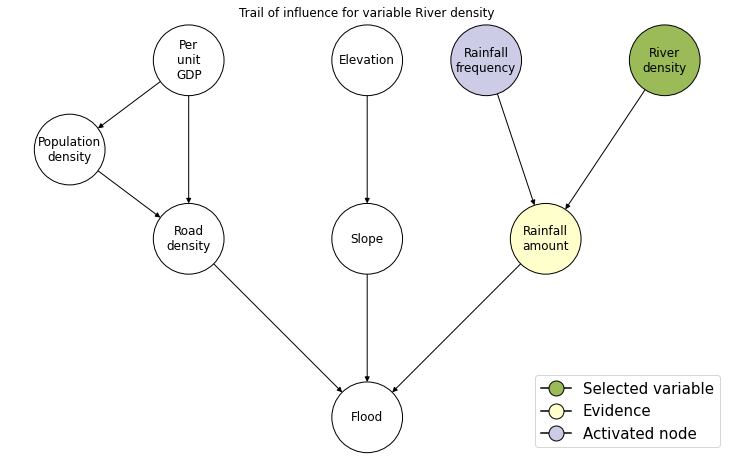

In [16]:
active_trail_nodes = model.active_trail_nodes(RIVER_DENSITY, observed=RAINFALL_AMOUNT)
print(f'Trail of influence for variable {RIVER_DENSITY}: {active_trail_nodes}')
plot_v_structure(model, RIVER_DENSITY, RAINFALL_AMOUNT, active_trail_nodes)

Example of blocked flow of information, since *Population density* is shielded by *Road density* and *Per unit GDP*.

In [17]:
print(model.active_trail_nodes(POPULATION_DENSITY, observed=[ROAD_DENSITY, PER_UNIT_GDP]))

{'Population density': {'Population density'}}


This result is obtained since the given evidence is exactly the *Markov Blanket* of *Population density*, which is confirmed by the `pgmpy` method `get_markov_blanket`.

In [18]:
model.get_markov_blanket(POPULATION_DENSITY)

['Road density', 'Per unit GDP']

## 2.4 Markov Blankets
The *Markov blankets* are computed through the `pgmpy` method `get_markov_blanket` and shown for each variable. No *trail of influence* is active for a variable when its *Markov blanket* is given as evidence.

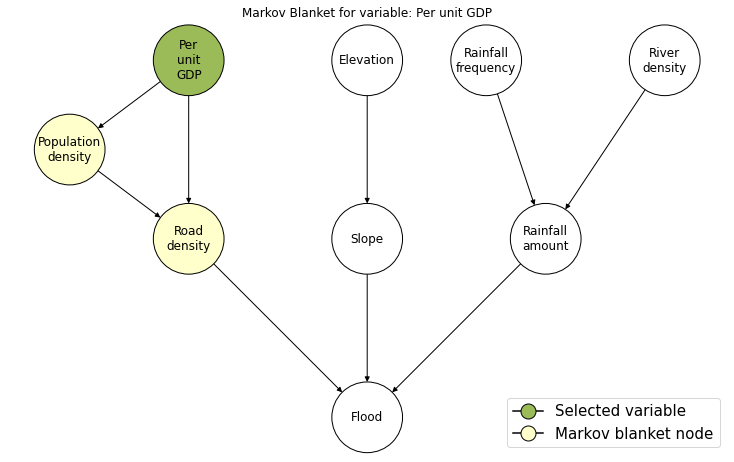

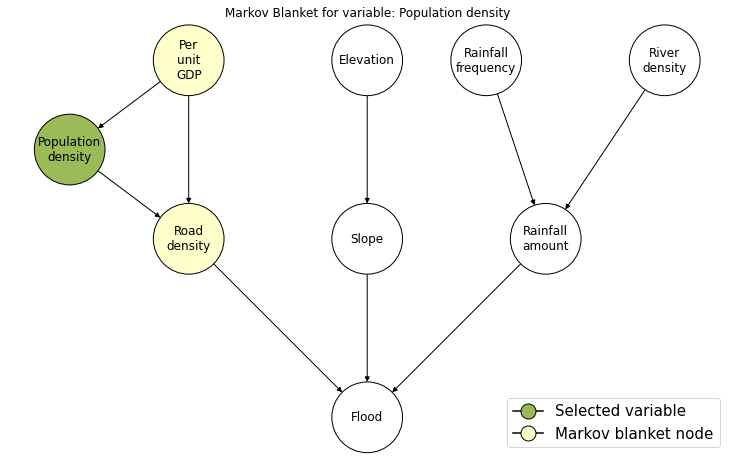

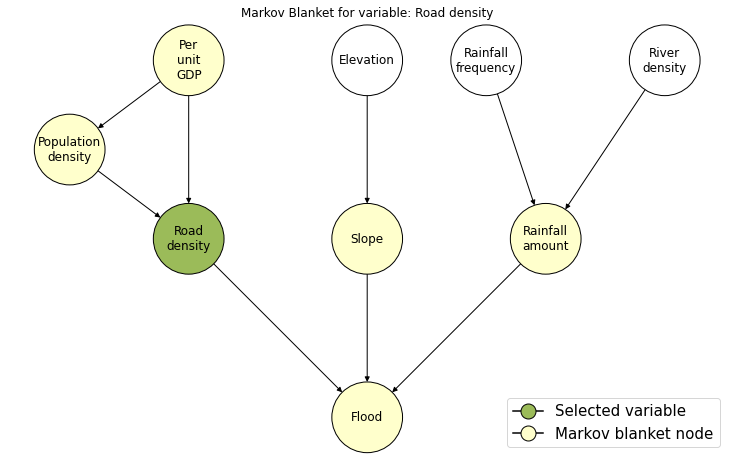

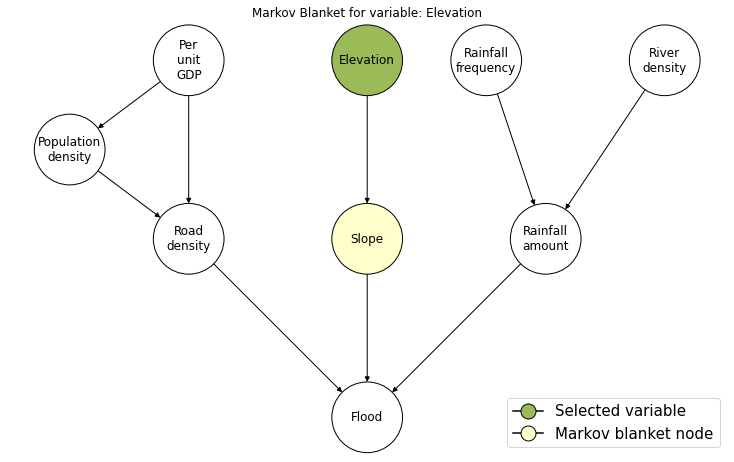

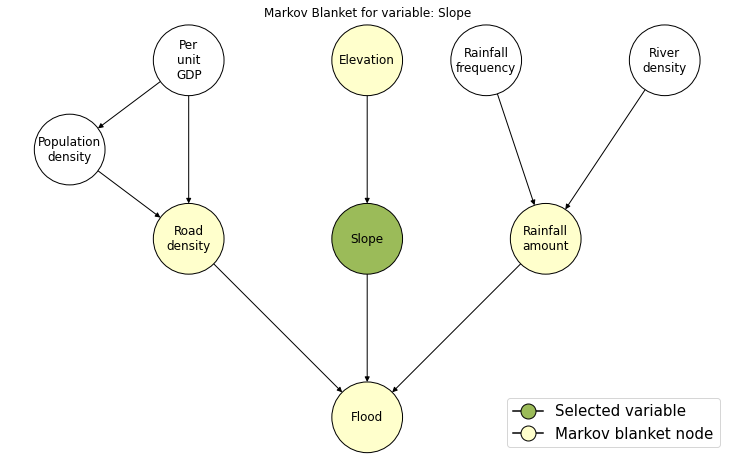

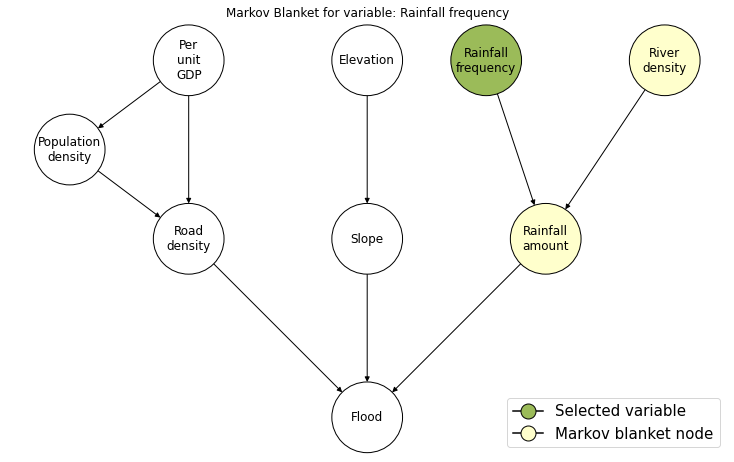

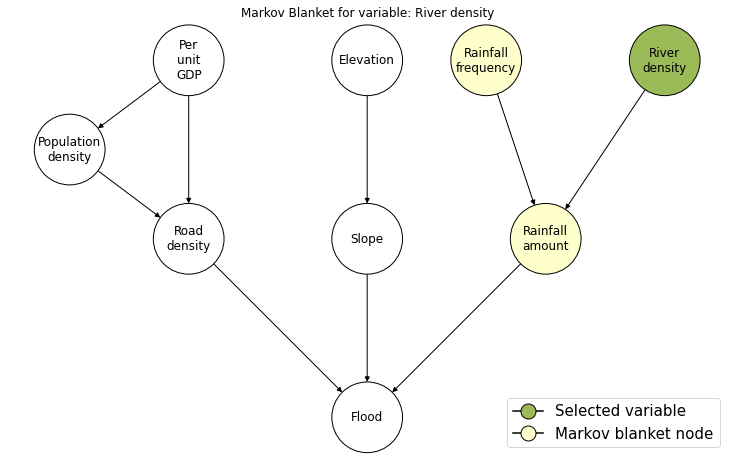

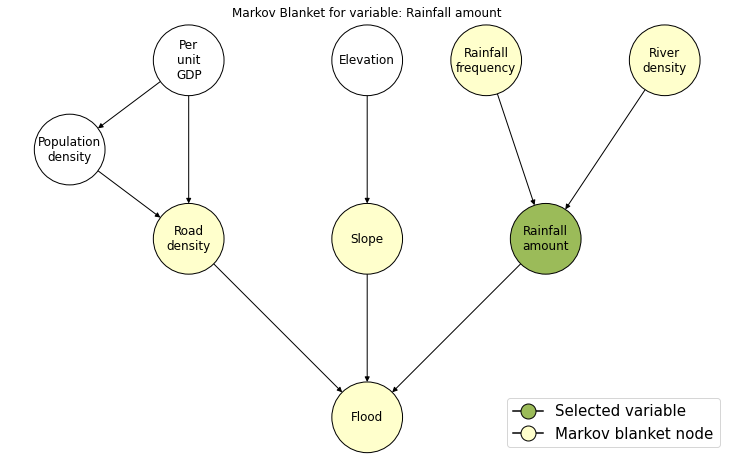

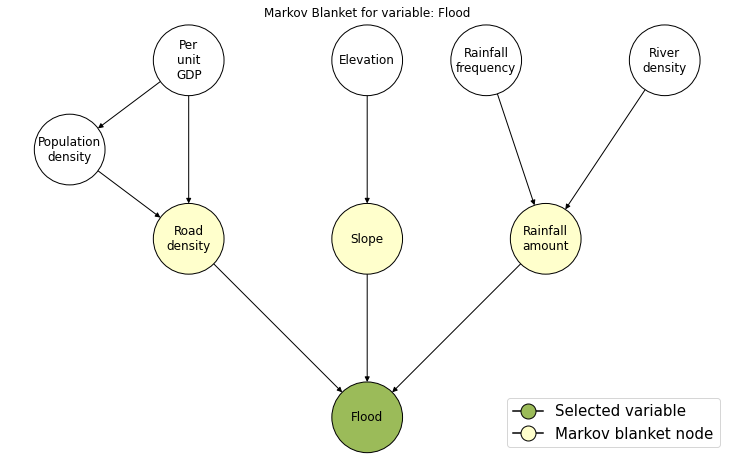

In [19]:
for v in variables:
    markov_blanket = model.get_markov_blanket(v)
    plot_markov_blanket (model, v, markov_blanket)
    print()

# 2.5 Exact inference

This section evaluates the exact inference on a series of variables given eventual evidence. The calculation is performed by using the Exact Inference method `VariableElimination.query` which applies the *Variable Elimination*.

In [20]:
exact_infer = VariableElimination(model)

**P(Flood)**

In [21]:
print_exact_inference(FLOOD, exact_infer)

Exact Inference to find P(Flood)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0785 |
+------------+--------------+
| Flood(No)  |       0.9215 |
+------------+--------------+
----- 0.0428818 seconds -----


**P(Flood | Road density = Dense)**

In [22]:
print_exact_inference(FLOOD, exact_infer, evidence={ROAD_DENSITY: 'Dense'})

Exact Inference to find P(Flood | Road density = Dense)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0999 |
+------------+--------------+
| Flood(No)  |       0.9001 |
+------------+--------------+
----- 0.0219414 seconds -----


**P(Flood | River density = Dense)**

In [23]:
print_exact_inference(FLOOD, exact_infer, evidence={RIVER_DENSITY: 'Dense'})

Exact Inference to find P(Flood | River density = Dense)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0938 |
+------------+--------------+
| Flood(No)  |       0.9062 |
+------------+--------------+
----- 0.0342058 seconds -----


**P(Flood | Road density = Dense, Slope = Flat)**

In [24]:
print_exact_inference(FLOOD, exact_infer, evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Flat'})

Exact Inference to find P(Flood | Road density = Dense, Slope = Flat)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.1159 |
+------------+--------------+
| Flood(No)  |       0.8841 |
+------------+--------------+
----- 0.0179526 seconds -----


**P(Flood | Road density = Dense, Slope = Flat, Rainfall Frequency = Frequent)**

In [25]:
print_exact_inference(FLOOD, exact_infer, evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Flat', RAINFALL_FREQUENCY: 'Frequent'})


Exact Inference to find P(Flood | Road density = Dense, Slope = Flat, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.1405 |
+------------+--------------+
| Flood(No)  |       0.8595 |
+------------+--------------+
----- 0.022937 seconds -----


**P(Flood | Road density = Medium, Slope = Flat, Rainfall Frequency = Frequent)**

In [26]:
print_exact_inference(FLOOD, exact_infer, evidence={ROAD_DENSITY: 'Medium', SLOPE: 'Flat', RAINFALL_FREQUENCY: 'Frequent'})

Exact Inference to find P(Flood | Road density = Medium, Slope = Flat, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0949 |
+------------+--------------+
| Flood(No)  |       0.9051 |
+------------+--------------+
----- 0.0209446 seconds -----


**P(Flood | Road density = Dense, Slope = Steep, Rainfall Frequency = Frequent)**

In [27]:
print_exact_inference(FLOOD, exact_infer, evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'})

Exact Inference to find P(Flood | Road density = Dense, Slope = Steep, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0485 |
+------------+--------------+
| Flood(No)  |       0.9516 |
+------------+--------------+
----- 0.0199498 seconds -----


**P(Slope)**

In [28]:
print_exact_inference(SLOPE, exact_infer)

Exact Inference to find P(Slope)

+--------------+--------------+
| Slope        |   phi(Slope) |
+==============+==============+
| Slope(Steep) |       0.2100 |
+--------------+--------------+
| Slope(Flat)  |       0.7900 |
+--------------+--------------+
----- 0.0089749 seconds -----


**P(Slope | Flood = Yes)**

In [29]:
print_exact_inference(SLOPE, exact_infer, evidence={FLOOD: 'Yes'})

Exact Inference to find P(Slope | Flood = Yes)

+--------------+--------------+
| Slope        |   phi(Slope) |
+==============+==============+
| Slope(Steep) |       0.0736 |
+--------------+--------------+
| Slope(Flat)  |       0.9264 |
+--------------+--------------+
----- 0.045876 seconds -----


**P(Rainfall Amount | Flood = Yes)**

In [30]:
print_exact_inference(RAINFALL_AMOUNT, exact_infer, evidence={FLOOD: 'Yes'})

Exact Inference to find P(Rainfall amount | Flood = Yes)

+-------------------------+------------------------+
| Rainfall amount         |   phi(Rainfall amount) |
+=========================+========================+
| Rainfall amount(Huge)   |                 0.7210 |
+-------------------------+------------------------+
| Rainfall amount(Medium) |                 0.2605 |
+-------------------------+------------------------+
| Rainfall amount(Little) |                 0.0185 |
+-------------------------+------------------------+
----- 0.0279244 seconds -----


**P(Rainfall Frequency | Rainfall Amount = Huge)**

In [31]:
print_exact_inference(RAINFALL_FREQUENCY, exact_infer, evidence={RAINFALL_AMOUNT: 'Huge'})

Exact Inference to find P(Rainfall frequency | Rainfall amount = Huge)

+------------------------------+---------------------------+
| Rainfall frequency           |   phi(Rainfall frequency) |
+==============================+===========================+
| Rainfall frequency(Frequent) |                    0.4157 |
+------------------------------+---------------------------+
| Rainfall frequency(Medium)   |                    0.5733 |
+------------------------------+---------------------------+
| Rainfall frequency(Rare)     |                    0.0110 |
+------------------------------+---------------------------+
----- 0.0099745 seconds -----


**P(Rainfall Frequency | Rainfall Amount = Little)**

In [32]:
print_exact_inference(RAINFALL_FREQUENCY, exact_infer, evidence={RAINFALL_AMOUNT: 'Little'})

Exact Inference to find P(Rainfall frequency | Rainfall amount = Little)

+------------------------------+---------------------------+
| Rainfall frequency           |   phi(Rainfall frequency) |
+==============================+===========================+
| Rainfall frequency(Frequent) |                    0.2021 |
+------------------------------+---------------------------+
| Rainfall frequency(Medium)   |                    0.5106 |
+------------------------------+---------------------------+
| Rainfall frequency(Rare)     |                    0.2872 |
+------------------------------+---------------------------+
----- 0.0209429 seconds -----


# 2.6 Approximate Inference

This section evaluates the approximate inference on a series of variables given evidence. The calculation is performed by using the Approximate Inference method `ApproxInference.query` which applies the *Rejection Sampling*. The results are compared with their *Exact Inference* counterpart.

### 2.6.1 Using Rejection Sampling

In [33]:
approx_infer_sampling = ExtendedApproxInference(model)

#### P(Flood)

In [34]:
print_exact_inference(FLOOD, exact_infer)
print()
print_approximate_inference(FLOOD, approx_infer_sampling, n_samples=1_000, random_state=RANDOM_STATE)

Exact Inference to find P(Flood)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0785 |
+------------+--------------+
| Flood(No)  |       0.9215 |
+------------+--------------+
----- 0.0359027 seconds -----

Approximate Inference with rejection sampling to find P(Flood)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(No)  |       0.9210 |
+------------+--------------+
| Flood(Yes) |       0.0790 |
+------------+--------------+
----- 0.0388969 seconds -----


The result shows that approximate inference gives a very good estimation of the probability distribution of Flood, since the values are very close the ones we get with exact inference. The main reason is that we used a very high number of samples, which approximates well the limit to infinity

#### P(Flood | Road Density = Dense, Slope = Steep, Rainfall Frequency = Frequent)

In [35]:
print_exact_inference(FLOOD, exact_infer, evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'})

print_approximate_inference(FLOOD, 
                            approx_infer_sampling, 
                            evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'}, 
                            n_samples=1_000, 
                            random_state=RANDOM_STATE)

Exact Inference to find P(Flood | Road density = Dense, Slope = Steep, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0485 |
+------------+--------------+
| Flood(No)  |       0.9516 |
+------------+--------------+
----- 0.0239355 seconds -----
Approximate Inference with rejection sampling to find P(Flood | Road density = Dense, Slope = Steep, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(No)  |       0.9560 |
+------------+--------------+
| Flood(Yes) |       0.0440 |
+------------+--------------+
----- 0.0399291 seconds -----


As for the case above, the estimation using approximate inference with rejection sampling is very good, since we used many samples. Unfortunatelly, this results in having a longer execution time than using exact inference, so there is no benefit in using approximate inference with those many samples.
Rather, we can dramatically decrease the number of samples and see what happens

In [36]:
print_approximate_inference(FLOOD, approx_infer_sampling, 
                            evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'}, 
                            n_samples=50, 
                            random_state=RANDOM_STATE)

Approximate Inference with rejection sampling to find P(Flood | Road density = Dense, Slope = Steep, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(No)  |       0.9400 |
+------------+--------------+
| Flood(Yes) |       0.0600 |
+------------+--------------+
----- 0.0329166 seconds -----


Approximate inference with rejection sampling does not work quiet well, giving results worse than the second case where more samples were given. In addition, the execution time has not changed a lot.

### Second case
#### P(Flood | Per unit GDP = Low, Elevation = Medium, Rainfall Frequency = Rare)

In [37]:
"""start_time = time.time_ns()

print("Exact Inference to find P(Flood | Per unit GDP = Dense, Slope = Flat, Rainfall Frequency = Frequent)\n")
print(exact_infer.query([FLOOD], 
                        evidence={PER_UNIT_GDP: 'Low', ELEVATION: 'Medium', RAINFALL_FREQUENCY: 'Rare'}, 
                        show_progress=False
))

print(f"--- {(time.time_ns() - start_time) / 1_000_000_000} seconds ---")

start_time = time.time_ns()

print("Approximate Inference with sampling to find P(Flood)\n")
print(approx_infer_sampling.query(variables=[FLOOD], 
                                  evidence={PER_UNIT_GDP: 'Low', ELEVATION: 'Medium', RAINFALL_FREQUENCY: 'Rare'}, 
                                  n_samples=1_000, show_progress=False, seed=RANDOM_STATE
))


print(f"--- {(time.time_ns() - start_time)  / 1_000_000_000} seconds ---")""";

As for the case above, the estimation using approximate inference with rejection sampling is very good, since we used many samples. Unfortunatelly, this results in having a longer execution time than using exact inference, so there is no benefit in using approximate inference with those many samples.
Rather, we can dramatically decrease the number of samples and see what happens

### Third case (few samples)
#### P(Flood | Per unit GDP = Low, Elevation = Medium, Rainfall Frequency = Rare)

In [38]:
"""start_time = time.time_ns()

print("Exact Inference to find P(Flood | Per unit GDP = Dense, Slope = Flat, Rainfall Frequency = Frequent)\n")
print(exact_infer.query([FLOOD], 
                        evidence={PER_UNIT_GDP: 'Low', ELEVATION: 'Medium', RAINFALL_FREQUENCY: 'Rare'}, 
                        show_progress=False
))

print(f"--- {(time.time_ns() - start_time) / 1_000_000_000} seconds ---")

start_time = time.time_ns()

print("Approximate Inference with sampling to find P(Flood)\n")
print(approx_infer_sampling.query(variables=[FLOOD], 
                                  evidence={PER_UNIT_GDP: 'Low', ELEVATION: 'Medium', RAINFALL_FREQUENCY: 'Rare'}, 
                                  n_samples=50, show_progress=False, seed=RANDOM_STATE
))


print(f"--- {(time.time_ns() - start_time)  / 1_000_000_000} seconds ---")""";

Approximate inference with rejection sampling does not work quiet well, giving results worse than the second case where more samples were given. In addition, the execution time has not changed a lot.

#### P(Flood | Road density = Dense, Slope = Flat, Rainfall Frequency = Frequent)
* Let's discuss the fact that the approximate inference should be maybe quicker rather than exact inference

In [39]:
"""start_time = time.time_ns()

print("Exact Inference to find P(Flood|Road density = Dense, Slope = Flat, Rainfall Frequency = Frequent)\n")
print(exact_infer.query([FLOOD], 
                        evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'}, 
                        show_progress=False
))

print(f"--- {(time.time_ns() - start_time) / 1_000_000_000} seconds ---")

start_time = time.time_ns()

print("Approximate Inference with sampling to find P(Flood)\n")
print(approx_infer_sampling.query(variables=[FLOOD], 
                                  evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'}, 
                                  n_samples=50, show_progress=False, seed=RANDOM_STATE
))


print(f"--- {(time.time_ns() - start_time)  / 1_000_000_000} seconds ---")""";

As for the case above, the estimation using approximate inference is very good, since we used many samples. Unfortunatelly, this results in having a longer execution time than using exact inference, so there is no benefit in using approximate inference with those many samples.
Rather, we can dramatically decrease the number of samples and see what happens

In [40]:
"""start_time = time.time_ns()

print("Approximate Inference with sampling to find P(Flood)\n")
print(approx_infer_sampling.query(variables=[FLOOD], evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'}, n_samples=1000, show_progress=False, seed=RANDOM_STATE))

print(f"--- {(time.time_ns() - start_time)  / 1_000_000_000} seconds ---")""";

Approximate inference still works quiet well, but gives results worse than the first try with more samples. In addition, the execution time is perfectly comparable to the one of exact inference

### 2.6.2 Using Likelihood Weighting

This section evaluates the approximate inference on a series of variables given evidence using the Likelihood Weighting method. The calculation is performed by using the `ApproxInferenceWeightedSampling.query` which extends the `ApproxInference.query` method by giving the option to use the *Likelihood Weighting* method on the *Bayesian Model*. The results are compared with their *Exact Inference* counterpart.

In [41]:
approx_infer_sampling = ExtendedApproxInference(model)

#### P(Flood)

In [42]:
print_exact_inference(FLOOD, exact_infer)
print()
print_approximate_inference(FLOOD, 
                            approx_infer_sampling, 
                            n_samples=1_000, 
                            random_state=RANDOM_STATE, 
                            use_weighted_likelihood=True)

Exact Inference to find P(Flood)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0785 |
+------------+--------------+
| Flood(No)  |       0.9215 |
+------------+--------------+
----- 0.0268994 seconds -----

Approximate Inference with weighted likelihood to find P(Flood)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(No)  |       0.9210 |
+------------+--------------+
| Flood(Yes) |       0.0790 |
+------------+--------------+
----- 0.0299192 seconds -----


The result shows that approximate inference gives a very good estimation of the probability distribution of Flood, since the values are very close the ones we get with exact inference. The main reason is that we used a very high number of samples, which approximates well the limit to infinity

#### P(Flood | Road Density = Dense, Slope = Steep, Rainfall Frequency = Frequent)

In [43]:
print_exact_inference(FLOOD, 
                      exact_infer, 
                      evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'})

print()

print_approximate_inference(FLOOD, 
                            approx_infer_sampling,
                            evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'}, 
                            n_samples=1_000, 
                            random_state=RANDOM_STATE, 
                            use_weighted_likelihood=True)

Exact Inference to find P(Flood | Road density = Dense, Slope = Steep, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(Yes) |       0.0485 |
+------------+--------------+
| Flood(No)  |       0.9516 |
+------------+--------------+
----- 0.0219443 seconds -----

Approximate Inference with weighted likelihood to find P(Flood | Road density = Dense, Slope = Steep, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(No)  |       0.9470 |
+------------+--------------+
| Flood(Yes) |       0.0530 |
+------------+--------------+
----- 0.2533226 seconds -----


As for the case above, the estimation using approximate inference with rejection sampling is very good, since we used many samples. Unfortunatelly, this results in having a longer execution time than using exact inference, so there is no benefit in using approximate inference with those many samples.
Rather, we can dramatically decrease the number of samples and see what happens

In [44]:
print_approximate_inference(FLOOD, 
                            approx_infer_sampling, 
                            evidence={ROAD_DENSITY: 'Dense', SLOPE: 'Steep', RAINFALL_FREQUENCY: 'Frequent'}, 
                            n_samples=50, 
                            random_state=RANDOM_STATE, 
                            use_weighted_likelihood=True)

Approximate Inference with weighted likelihood to find P(Flood | Road density = Dense, Slope = Steep, Rainfall frequency = Frequent)

+------------+--------------+
| Flood      |   phi(Flood) |
+============+==============+
| Flood(No)  |       0.9800 |
+------------+--------------+
| Flood(Yes) |       0.0200 |
+------------+--------------+
----- 0.0579 seconds -----


Approximate inference with weighted likelihood sampling does not work quiet well, giving results worse than the second case where more samples were given. In addition, the execution time has not changed a lot.

#### P(Flood | Per unit GDP = Low, Elevation = Medium, Rainfall Frequency = Rare)
* Let's discuss the fact that the approximate inference should be maybe quicker rather than exact inference

In [45]:
"""start_time = time.time_ns()

evidence_to_use = {PER_UNIT_GDP: 'Low', ELEVATION: 'Medium', RAINFALL_FREQUENCY: 'Rare'}

print("Exact Inference to find P(Flood|Road density = Dense, Slope = Flat, Rainfall Frequency = Frequent)\n")
print(exact_infer.query([FLOOD], evidence=evidence_to_use, show_progress=False))

print(f"--- {(time.time_ns() - start_time) / 1_000_000_000} seconds ---")

start_time = time.time_ns()

print("Approximate Inference with sampling to find P(Flood)\n")
print(approx_infer_sampling.query(variables=[FLOOD], evidence=evidence_to_use, n_samples=100, show_progress=False, 
                                  use_weighted_sampling=True, seed=RANDOM_STATE))


print(f"--- {(time.time_ns() - start_time)  / 1_000_000_000} seconds ---")""";

### 2.6.3 Using Markov Chain Monte Carlo Method

In [46]:
gibbs = GibbsSampling(model)
gibbs_df = gibbs.sample(size=10_000, seed=RANDOM_STATE)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [47]:
gibbs_df['Flood'].value_counts()

1    9218
0     782
Name: Flood, dtype: int64

#### P(Flood)

In [48]:
series_Flood = gibbs_df['Flood'].value_counts()

#Flood  Yes:0, No:1
print('Phi(Flood = Yes): ',series_Flood[0]/(sum(series_Flood)) )
print('Phi(Flood = No): ',series_Flood[1]/(sum(series_Flood)) )

Phi(Flood = Yes):  0.0782
Phi(Flood = No):  0.9218


#### P(Flood  | Per unit GDP = High)

In [49]:
#GDP High: 0, Medium: 1, Low: 2
series_Flood_GDP = gibbs_df.loc[gibbs_df['Per unit GDP'] == 0]['Flood'].value_counts()

#Flood  Yes:0, No:1
print('Phi(Flood = Yes | Per unit GDP = High): ',series_Flood_GDP[0]/(sum(series_Flood_GDP)) )
print('Phi(Flood = No | Per unit GDP = High): ',series_Flood_GDP[1]/(sum(series_Flood_GDP)) )

Phi(Flood = Yes | Per unit GDP = High):  0.08849557522123894
Phi(Flood = No | Per unit GDP = High):  0.911504424778761


# 3 Use Case

In this section an use case for the implemented Bayesian Network is presented. 

We decided to test the performance of our qualitative built network by using relevant information related to each municipality of the Italian Veneto region.
In particular, the chance of flooding on a yearly basis of each municipality is computed through *Exact inference* given as evidence frequent rainfalls for the period (**Rainfall Frequency = Frequent**) and each municipality information about the **Per unit GDP**, **Population density**, **Slope** and **River density**.

$$ \forall \ m \in \text{Municipalities}, P(\text{Flood}_m\ | \ \text{Per unit GDP}_m, \text{Population density}_m, \text{Slope}_m,\text{River density}_m, \text{Rainfall frequency = Frequent})$$

## 3.1 Municipalities data
The municipalities data needed to perform the inference is obtained throgh different reliabe sources (e.g.: the *Ministry of Economy and Finance* of Italy, the *Italian National Institute of Statistics* or the Veneto Region official web platform) and it is collected in a `pandas` `DataFrame`.

The sources of each piece of information are expressed below:
* Municipalities general information and regional incomes: https://www1.finanze.gov.it/finanze/analisi_stat/public/index.php?tree=2020
* Municipalities surfaces: https://data.europa.eu/data/datasets/superficie_territoriale_in_kmq_dei_comuni_del_veneto?locale=it
* Municipalities population: https://www.istat.it/it/archivio/243448
* Municipalities water surfaces: https://www.regione.veneto.it/web/ambiente-e-territorio/scheda-dati
* Municipalities altitudes: https://www.istat.it/it/archivio/156224

Missing data has been filled according to the municipalities information given by the following websites:
* https://it.wikipedia.org/wiki/Pagina_principale
* https://www.cittaeborghi.it/it/

Useful constants for data manipulation are expressed below

In [50]:
ISTAT_VENETO_CODE = 5
MUNICIPALITY_NAME_COLUMN = 'Municipality Name'
ISTAT_CODE_COLUMN = 'Istat code'
PROVINCE_COLUMN = 'Province'
SURFACE_COLUMN = 'Surface (km2)'

### 3.1.1 Main dataframe
The main dataframe (`df`) is created by exploiting the information given by the region's income data (`income_df`)

The `income_df` is created and inspected.

In [51]:
income_df = pd.read_csv('./data/Redditi_e_principali_variabili_IRPEF_su_base_comunale_CSV_2019.csv', sep=';', index_col=False)
income_df.head()

,Anno di imposta,Codice catastale,Codice Istat Comune,Denominazione Comune,Sigla Provincia,Regione,Codice Istat Regione,Numero contribuenti,Reddito da fabbricati - Frequenza,Reddito da fabbricati - Ammontare in euro,...,Reddito complessivo da 15000 a 26000 euro - Ammontare in euro,Reddito complessivo da 26000 a 55000 euro - Frequenza,Reddito complessivo da 26000 a 55000 euro - Ammontare in euro,Reddito complessivo da 55000 a 75000 euro - Frequenza,Reddito complessivo da 55000 a 75000 euro - Ammontare in euro,Reddito complessivo da 75000 a 120000 euro - Frequenza,Reddito complessivo da 75000 a 120000 euro - Ammontare in euro,Reddito complessivo oltre 120000 euro - Frequenza,Reddito complessivo oltre 120000 euro - Ammontare in euro,
0,2019,A001,28001,ABANO TERME,PD,Veneto,5,14954,7477.0,10358625.0,...,100630146,3472.0,121942029.0,438.0,27886866.0,396.0,36808564.0,187.0,38228141.0,NaN
1,2019,A004,98001,ABBADIA CERRETO,LO,Lombardia,3,205,86.0,66213.0,...,1614434,46.0,1489603.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,2019,A005,97001,ABBADIA LARIANA,LC,Lombardia,3,2441,1193.0,1723810.0,...,17001505,671.0,23138246.0,74.0,4698905.0,48.0,4328711.0,31.0,6397476.0,NaN
3,2019,A006,52001,ABBADIA SAN SALVATORE,SI,Toscana,9,4876,2635.0,2827574.0,...,37044603,796.0,27215546.0,68.0,4342264.0,32.0,2960972.0,9.0,1435917.0,NaN
4,2019,A007,95001,ABBASANTA,OR,Sardegna,20,1731,875.0,766745.0,...,9187754,433.0,14540500.0,24.0,1572949.0,10.0,908389.0,NaN,NaN,NaN


`income_df` is reduced to the sole municipalities of the Veneto region, which are 563.

In [52]:
income_df = income_df[income_df['Codice Istat Regione'] == ISTAT_VENETO_CODE]
income_df.reset_index(inplace=True)
income_df.shape

(563, 52)

The main dataframe (`df`) is created using the `income_df`.

In [53]:
df = income_df[['Denominazione Comune', 'Codice Istat Comune', 'Sigla Provincia']]

df = df.rename(columns={
    'Denominazione Comune': MUNICIPALITY_NAME_COLUMN, 
    'Codice Istat Comune': ISTAT_CODE_COLUMN, 
    'Sigla Provincia': PROVINCE_COLUMN
})

df.head()

,Municipality Name,Istat code,Province
0,ABANO TERME,28001,PD
1,ADRIA,29001,RO
2,AFFI,23001,VR
3,AGNA,28002,PD
4,AGORDO,25001,BL


No missing values are present in the newly created `df`.

In [54]:
print('Number of NaN values in df: \n{}'.format(df.isna().sum()))

Number of NaN values in df: 
Municipality Name    0
Istat code           0
Province             0
dtype: int64


### 3.1.2 Per unit GDP information

Information needed to computed the **Per unit GDP** values is inspected, and it is available for each municipality

In [55]:
print('Number of NaN values regarding the total amount of income: {}'.format(
    income_df['Reddito imponibile - Ammontare in euro'].isna().sum())
     )
print('Number of NaN values regarding the total amount of tax payers: {}'.format(income_df['Numero contribuenti'].isna().sum()))

Number of NaN values regarding the total amount of income: 0
Number of NaN values regarding the total amount of tax payers: 0


The **Per unit GDP** data is computed by dividing for each region the total income by the number of tax payers given by the `income_df` and the column is added to the main `df`.

In [56]:
df[PER_UNIT_GDP] = income_df['Reddito imponibile - Ammontare in euro'] / income_df['Numero contribuenti']
df.head()

,Municipality Name,Istat code,Province,Per unit GDP
0,ABANO TERME,28001,PD,22672.425104
1,ADRIA,29001,RO,19309.673843
2,AFFI,23001,VR,20106.002743
3,AGNA,28002,PD,17973.677643
4,AGORDO,25001,BL,23715.945362


### 3.1.3 Population density information

Information needed to computed the **Population density** values is obtained by firstly creating the `population_density_df` and then merging the density per $km^2$ information into the main `df`.

In [57]:
population_density_df = pd.read_excel('./data/05_Veneto_Allegato-statistico.xlsx', 'Appendice 2',  skiprows = 10)
population_density_df = population_density_df[['ProCom', 'Densità']]
population_density_df.head()

,ProCom,Densità
0,23001,239.1
1,23002,186.3
2,23003,168.2
3,23004,336.2
4,23005,97.9


In [58]:
df = pd.merge(df, population_density_df, left_on=ISTAT_CODE_COLUMN, right_on='ProCom', how='left').drop('ProCom', axis=1)

df = df.rename(columns={'Densità': POPULATION_DENSITY})

Missing information is filled and the main `df` is shown.

In [59]:
print('Rows of df where "{}" is NaN.'.format(POPULATION_DENSITY))

df[df[POPULATION_DENSITY].isna()]

Rows of df where "Population density" is NaN.


,Municipality Name,Istat code,Province,Per unit GDP,Population density
558,BORGO VALBELLUNA,25074,BL,19460.162789,NaN
559,PIEVE DEL GRAPPA,26096,TV,18093.788296,NaN
560,VALBRENTA,24125,VI,17956.865122,NaN
561,COLCERESA,24126,VI,19783.550410,NaN
562,LUSIANA CONCO,24127,VI,17003.585115,NaN


In [60]:
df.loc[558, POPULATION_DENSITY] = 80.15
df.loc[559, POPULATION_DENSITY] = 175.74
df.loc[560, POPULATION_DENSITY] = 53.28
df.loc[561, POPULATION_DENSITY] = 307.63
df.loc[562, POPULATION_DENSITY] = 76.32

In [61]:
df.head()

,Municipality Name,Istat code,Province,Per unit GDP,Population density
0,ABANO TERME,28001,PD,22672.425104,946.5
1,ADRIA,29001,RO,19309.673843,170.6
2,AFFI,23001,VR,20106.002743,239.1
3,AGNA,28002,PD,17973.677643,171.8
4,AGORDO,25001,BL,23715.945362,173.4


### 3.1.4 Slope information

Information needed to computed the **Slope** values is obtained by firstly creating the `elevation_df`, next and then merging the altitude range information of each municipality (expressed in $mts$) into the main `df`.

In [62]:
elevation_df = pd.read_excel('./data/Elab_Altimetrie_DEM.xlsx')
elevation_df.head()

,COD_REG,COD_PRO,PRO_COM,NOME,SUPERFICIE (in KMQ),ALT_MIN,ALT_MAX,RANGE,MEDIA,MEDIANA,STD
0,12,58,58120,Fiumicino,213.8944,-3,164,167,31.688450,5,39.686070
1,5,29,29001,Adria,113.3900,-3,8,11,1.057863,1,1.244239
2,5,29,29030,Loreo,39.8442,-3,7,10,0.464185,0,0.770743
3,5,29,29052,Porto Viro,133.7686,-3,6,9,0.555705,1,0.553657
4,8,38,38017,Ostellato,173.3434,-3,8,11,1.784421,1,0.977924


In [63]:
elevation_df = elevation_df[elevation_df['COD_REG'] == ISTAT_VENETO_CODE]
elevation_df = elevation_df.rename(columns={'RANGE': SLOPE,})
elevation_df = elevation_df[['PRO_COM', SLOPE]]

df = pd.merge(
    df, 
    elevation_df, 
    left_on=ISTAT_CODE_COLUMN,
    right_on='PRO_COM', 
    how = 'left'
).drop('PRO_COM', axis=1)

Missing information is filled and the main `df` is shown.

In [64]:
print('Rows of df where "{}" is NaN.'.format(SLOPE))

df[df[SLOPE].isna()]

Rows of df where "Slope" is NaN.


,Municipality Name,Istat code,Province,Per unit GDP,Population density,Slope
551,QUERO VAS,25070,BL,18012.158351,68.50,NaN
552,LONGARONE,25071,BL,19326.091770,42.50,NaN
553,VAL DI ZOLDO,25073,BL,15285.987690,22.30,NaN
554,ALPAGO,25072,BL,19631.981083,85.30,NaN
555,VAL LIONA,24123,VI,20148.390223,110.70,NaN
556,BARBARANO MOSSANO,24124,VI,18563.440208,191.80,NaN
557,BORGO VENETO,28107,PD,17286.636487,178.70,NaN
558,BORGO VALBELLUNA,25074,BL,19460.162789,80.15,NaN
559,PIEVE DEL GRAPPA,26096,TV,18093.788296,175.74,NaN
560,VALBRENTA,24125,VI,17956.865122,53.28,NaN


In [65]:
df.loc[551, SLOPE] = 1625 - 175
df.loc[552, SLOPE] = 2502 - 400 
df.loc[553, SLOPE] = 3210 - 593
df.loc[554, SLOPE] = 2471 - 380
df.loc[555, SLOPE] = 320 - 15
df.loc[556, SLOPE] = 445 - 15
df.loc[557, SLOPE] = 22 - 7

# Ulterior missing (and unavailable) information was filled by the mean value of "Slope" across the whole dataset.
df[SLOPE].fillna(df[SLOPE].mean(), inplace=True)

In [66]:
df.head()

,Municipality Name,Istat code,Province,Per unit GDP,Population density,Slope
0,ABANO TERME,28001,PD,22672.425104,946.5,70.0
1,ADRIA,29001,RO,19309.673843,170.6,11.0
2,AFFI,23001,VR,20106.002743,239.1,248.0
3,AGNA,28002,PD,17973.677643,171.8,3.0
4,AGORDO,25001,BL,23715.945362,173.4,2329.0


### 3.1.5 River density

Information needed to computed the **River density** values is obtained by firstly creating the `river_density_df`.

In [67]:
river_density_df = pd.read_excel('./data/codiceISTAT_schedaLR14_2017.ods', 'ISTAT')
river_density_df.head()

,cod. comune,comune,Provincia,Superficie Territoriale,Alta Tens. Abitativa,Cl. Sismica,Zona Altimetrica,Com.Litoraneo,m2 classe 1.1,m2 classe 1.2,m2 classe 1.3,m2 classe 1.4,classe_ 2,classe_3,classe_4,classe_5
0,23001,Affi,Verona,9.799115e+06,NO,3,C,NO,9.004371e+05,1.184847e+06,111488.771911,94334.549293,4.988987e+06,2.519021e+06,0,0.000000
1,23002,Albaredo d'Adige,Verona,2.806956e+07,NO,3,P,NO,2.435867e+06,1.573058e+06,77486.309329,83747.221385,2.248276e+07,5.606045e+05,10028.032285,846009.657850
2,23003,Angiari,Verona,1.342630e+07,NO,4,P,NO,1.060541e+06,8.997925e+05,404694.873533,32775.778874,1.024552e+07,2.044952e+05,7131.331046,571346.642105
3,23004,Arcole,Verona,1.893525e+07,NO,3,P,NO,2.142434e+06,1.410993e+06,96287.506907,74127.854180,1.520780e+07,3.744673e+04,0,69497.743789
4,23005,Badia Calavena,Verona,2.674027e+07,NO,2,M,NO,1.087524e+06,5.244485e+05,54086.253086,14338.349984,9.144607e+06,1.575538e+07,0,159884.900683


Next, the **River density** information is obtained by dividing the surface of water of each municipality (`classe_5`) by its surface (`Superficie Territoriale`) and the `river_density_df` dataset is reduced with the solely needed features.

In [68]:
river_density_df[RIVER_DENSITY] = river_density_df['classe_5'] / river_density_df['Superficie Territoriale']
river_density_df = river_density_df[['cod. comune', RIVER_DENSITY]]
river_density_df.head()

,cod. comune,River density
0,23001,0.000000
1,23002,0.030140
2,23003,0.042554
3,23004,0.003670
4,23005,0.005979


The **River density** information of each municipality (expressed in a value between 0 and 1) is merged into the main `df`.

In [69]:
df = pd.merge(
    df, 
    river_density_df, 
    left_on=ISTAT_CODE_COLUMN,
    right_on='cod. comune', 
    how = 'left'
).drop('cod. comune', axis=1)

Missing information is filled by the mean value of **River density** across the dataset and the main `df` is shown.

In [70]:
print('Rows of df where "{}" is NaN.'.format(RIVER_DENSITY))

df[df[RIVER_DENSITY].isna()]

Rows of df where "River density" is NaN.


,Municipality Name,Istat code,Province,Per unit GDP,Population density,Slope,River density
556,BARBARANO MOSSANO,24124,VI,18563.440208,191.80,430.000000,NaN
557,BORGO VENETO,28107,PD,17286.636487,178.70,15.000000,NaN
558,BORGO VALBELLUNA,25074,BL,19460.162789,80.15,434.258065,NaN
559,PIEVE DEL GRAPPA,26096,TV,18093.788296,175.74,434.258065,NaN
560,VALBRENTA,24125,VI,17956.865122,53.28,434.258065,NaN
561,COLCERESA,24126,VI,19783.550410,307.63,434.258065,NaN
562,LUSIANA CONCO,24127,VI,17003.585115,76.32,434.258065,NaN


In [71]:
df[RIVER_DENSITY].fillna(df[RIVER_DENSITY].mean(), inplace=True)

df.head()

,Municipality Name,Istat code,Province,Per unit GDP,Population density,Slope,River density
0,ABANO TERME,28001,PD,22672.425104,946.5,70.0,0.003281
1,ADRIA,29001,RO,19309.673843,170.6,11.0,0.043392
2,AFFI,23001,VR,20106.002743,239.1,248.0,0.000000
3,AGNA,28002,PD,17973.677643,171.8,3.0,0.012827
4,AGORDO,25001,BL,23715.945362,173.4,2329.0,0.004915


## 3.2 Data discretization
The municipalities data collected in `df` is discretized according to the information used to build the *Bayesian Network* or their *exact inference* when the variables have parent nodes in the network.

In [72]:
per_unit_gdp_inference = exact_infer.query([PER_UNIT_GDP], show_progress=False)
population_density_inference = exact_infer.query([POPULATION_DENSITY], show_progress=False)
slope_inference = exact_infer.query([SLOPE], show_progress=False)
river_density_inference = exact_infer.query([RIVER_DENSITY], show_progress=False)

The infered data shown above is used to discretize the `df` data according to specific quantiles.

In [73]:
apply_discrete_values(PER_UNIT_GDP, df, [
    df[PER_UNIT_GDP].min(),
    df[PER_UNIT_GDP].quantile(per_unit_gdp_inference.values[-1]),
    df[PER_UNIT_GDP].quantile(1 - per_unit_gdp_inference.values[0]),
    df[PER_UNIT_GDP].max()
], state_names_dictionary)

apply_discrete_values(SLOPE, df, [
    df[SLOPE].min(),
    df[SLOPE].quantile(slope_inference.values[-1]),
    df[SLOPE].max()
], state_names_dictionary)

apply_discrete_values(POPULATION_DENSITY, df, [
    df[POPULATION_DENSITY].min(),
    df[POPULATION_DENSITY].quantile(population_density_inference.values[-1]),
    df[POPULATION_DENSITY].quantile(1 - population_density_inference.values[0]),
    df[POPULATION_DENSITY].max()
], state_names_dictionary)

apply_discrete_values(RIVER_DENSITY, df, [
    df[RIVER_DENSITY].min(),
    df[RIVER_DENSITY].quantile(river_density_inference.values[-1]),
    df[RIVER_DENSITY].max()
], state_names_dictionary)

In [74]:
df.head()

,Municipality Name,Istat code,Province,Per unit GDP,Population density,Slope,River density
0,ABANO TERME,28001,PD,High,Dense,Flat,Sparse
1,ADRIA,29001,RO,Medium,Medium,Flat,Dense
2,AFFI,23001,VR,Medium,Medium,Flat,Sparse
3,AGNA,28002,PD,Medium,Medium,Flat,Dense
4,AGORDO,25001,BL,High,Medium,Steep,Sparse


## 3.3 Likelihood of flooding

The chance of flooding on a yearly basis of each municipality is computed through *Exact inference* given as evidence frequent rainfalls for the period (**Rainfall Frequency = Frequent**) and each municipality information about the **Per unit GDP**, **Population density**, **Slope** and **River density**.

$$ \forall \ m \in \text{Municipalities}, P(\text{Flood}_m\ | \ \text{Per unit GDP}_m, \text{Population density}_m, \text{Slope}_m,\text{River density}_m, \text{Rainfall frequency = Frequent})$$

In [75]:
df['flood_likelihood'] = df.apply(
    lambda row: exact_infer.query([FLOOD], evidence={
        PER_UNIT_GDP: row[PER_UNIT_GDP], 
        POPULATION_DENSITY: row[POPULATION_DENSITY], 
        SLOPE: row[SLOPE], 
        RIVER_DENSITY: row[RIVER_DENSITY],
        RAINFALL_FREQUENCY: 'Frequent'
    }, show_progress=False).get_value(Flood='Yes'), 
    axis=1
)

In [76]:
df.head()

,Municipality Name,Istat code,Province,Per unit GDP,Population density,Slope,River density,flood_likelihood
0,ABANO TERME,28001,PD,High,Dense,Flat,Sparse,0.118635
1,ADRIA,29001,RO,Medium,Medium,Flat,Dense,0.125922
2,AFFI,23001,VR,Medium,Medium,Flat,Sparse,0.100055
3,AGNA,28002,PD,Medium,Medium,Flat,Dense,0.125922
4,AGORDO,25001,BL,High,Medium,Steep,Sparse,0.037695


The `geopandas_df` is created in order to represent each municipality as a geometrical 2-dimensional shape and to plot a map of the Veneto region divided in municipalities with information about the flood chances.

The data has been fetched from the following site:
* https://github.com/openpolis/geojson-italy

In [77]:
geopandas_df = gpd.read_file('https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_R_5_municipalities.geojson')

In [78]:
geopandas_df.head()

,name,minint_finloc,minint_elettorale,op_id,prov_name,prov_istat_code,prov_istat_code_num,prov_acr,reg_name,reg_istat_code,reg_istat_code_num,opdm_id,com_catasto_code,com_istat_code,com_istat_code_num,geometry
0,Affi,2050890010,1050890010,3216,Verona,023,23,VR,Veneto,05,5,3080,A061,023001,23001,"POLYGON ((10.80227 45.54440, 10.80002 45.54523..."
1,Albaredo d'Adige,2050890020,1050890020,3217,Verona,023,23,VR,Veneto,05,5,3081,A137,023002,23002,"POLYGON ((11.31571 45.27510, 11.30181 45.27369..."
2,Angiari,2050890030,1050890030,3218,Verona,023,23,VR,Veneto,05,5,3082,A292,023003,23003,"POLYGON ((11.26925 45.24528, 11.27418 45.24299..."
3,Arcole,2050890040,1050890040,3219,Verona,023,23,VR,Veneto,05,5,3083,A374,023004,23004,"POLYGON ((11.33498 45.38570, 11.32820 45.37363..."
4,Badia Calavena,2050890050,1050890050,3220,Verona,023,23,VR,Veneto,05,5,3084,A540,023005,23005,"POLYGON ((11.19320 45.59279, 11.18963 45.58946..."


The number of municipalities of `geopandas_df` corresponds to the ones of `df`.

In [79]:
print((geopandas_df.shape[0], df.shape[0]))

(563, 563)


The **Flood likelihood** information for each municipality (expressed in a value between 0 and 1) is merged into the `geopandas_df`.

In [80]:
geopandas_df = pd.merge(
    geopandas_df, 
    df[['Istat code','flood_likelihood']], 
    left_on='com_istat_code_num',
    right_on='Istat code', 
    how = 'left'
).drop('Istat code', axis=1)

In [81]:
geopandas_df.head()

,name,minint_finloc,minint_elettorale,op_id,prov_name,prov_istat_code,prov_istat_code_num,prov_acr,reg_name,reg_istat_code,reg_istat_code_num,opdm_id,com_catasto_code,com_istat_code,com_istat_code_num,geometry,flood_likelihood
0,Affi,2050890010,1050890010,3216,Verona,023,23,VR,Veneto,05,5,3080,A061,023001,23001,"POLYGON ((10.80227 45.54440, 10.80002 45.54523...",0.100055
1,Albaredo d'Adige,2050890020,1050890020,3217,Verona,023,23,VR,Veneto,05,5,3081,A137,023002,23002,"POLYGON ((11.31571 45.27510, 11.30181 45.27369...",0.125922
2,Angiari,2050890030,1050890030,3218,Verona,023,23,VR,Veneto,05,5,3082,A292,023003,23003,"POLYGON ((11.26925 45.24528, 11.27418 45.24299...",0.143361
3,Arcole,2050890040,1050890040,3219,Verona,023,23,VR,Veneto,05,5,3083,A374,023004,23004,"POLYGON ((11.33498 45.38570, 11.32820 45.37363...",0.108155
4,Badia Calavena,2050890050,1050890050,3220,Verona,023,23,VR,Veneto,05,5,3084,A540,023005,23005,"POLYGON ((11.19320 45.59279, 11.18963 45.58946...",0.100055


### 3.3.1 Flood chances heatmap

Finally, a heatmap showing the probability of flood for each municipality is shown.

The results are significative, since it is evdent how the northern areas where the slope of the surface is steeper have lower chances of being flooded, although there may be some exception, like in places near *Belluno*, which are zones with a high elevation, but with a quite flat surface resulting in higher probabilities of flooding.

More densely populated and richer areas such as some chief towns (*Venezia*, *Verona*, *Vicenza*, *Padova* and *Rovigo*) have the highest likelihood of experiencing floods, whereas poorer and less populated although quietly flat areas in the southern regions show medium probabilities of being flooded.

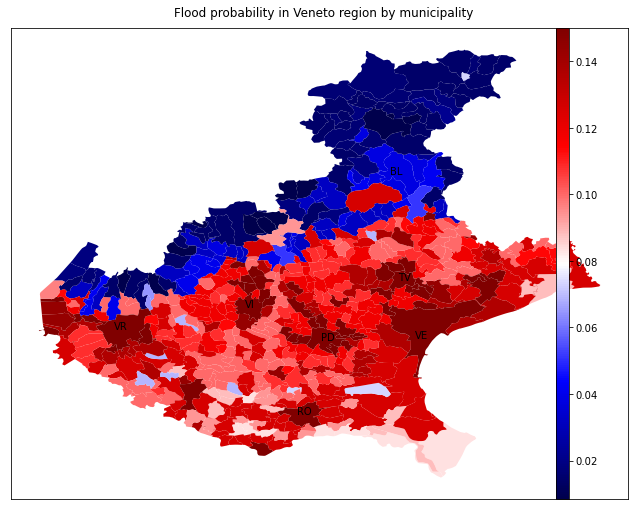

In [82]:
fig, ax = plt.subplots(1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=-1)

ax = geopandas_df.plot(column='flood_likelihood', cmap='seismic', ax=ax, legend= True, cax=cax)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

provinces = ['Venezia', 'Verona', 'Vicenza', 'Padova', 'Treviso', 'Rovigo', 'Belluno']

for idx, row in geopandas_df[geopandas_df['name'].isin(provinces)].iterrows():
    coords = row['geometry'].representative_point().coords[:]
    coords = coords[0]
    ax.annotate(row['prov_acr'], xy=coords, horizontalalignment='center')
    
fig.suptitle('Flood probability in Veneto region by municipality', y=0.86, x=0.56)
plt.show()